# German Traffic Sign Classification

---

In [308]:
import pandas as pd

df_total = pd.DataFrame()
for i in range(0,43):
    csv_file = '..\..\datasets\GTSRB_data\Final_Training\Images\%05d\GT-%05d.csv' % (i, i)
    the_path = '..\..\datasets\GTSRB_data\Final_Training\Images\%05d\\' % (i) 
    df=pd.read_csv(csv_file)
    df['Filename'] = the_path + df['Filename'] # prepend path to filename
    df_total = df_total.append(df) # append all dataframes to df_total
    
df_total.info() # display some information
#df_total['Filename'].head() # look at a few rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39209 entries, 0 to 239
Data columns (total 9 columns):
Filename    39209 non-null object
Width       39209 non-null int64
Height      39209 non-null int64
Roi.X1      39209 non-null int64
Roi.Y1      39209 non-null int64
Roi.X2      39209 non-null int64
Roi.Y2      39209 non-null int64
ClassId     39209 non-null int64
Damage      39209 non-null int64
dtypes: int64(8), object(1)
memory usage: 3.0+ MB


In [309]:
df_total = df_total.astype({"Damage": str}) # convert damage column to string
#df_total.info()

In [310]:
# create trn, val, tst split
import math
from sklearn.utils import shuffle
df_total_shuffled = shuffle(df_total, random_state=42)

trn_percentage = 0.8 # use 80 for training
val_percentage = 0.9 # use samples 0.8 to 0.9 for validation, rest for testing

trn_split = math.floor(len(df_total_shuffled)*trn_percentage)
val_split = math.floor(len(df_total_shuffled)*val_percentage)

df_trn = df_total_shuffled.iloc[0:trn_split]
df_val = df_total_shuffled.iloc[trn_split:val_split]
df_tst = df_total_shuffled.iloc[val_split:]

# check if sizes are correct
print(len(df_train))
print(len(df_val))
print(len(df_tst))
print(len(df_trn) + len(df_val) + len(df_tst))
print(len(df_total_shuffled))

df_trn.groupby('Damage').count()
#df_val.groupby('Damage').count()
#df_tst.groupby('Damage').count()

31367
3921
3921
39209
39209


,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
Damage,,,,,,,,
0,28385,28385,28385,28385,28385,28385,28385,28385
1,2982,2982,2982,2982,2982,2982,2982,2982


In [311]:
from keras_preprocessing.image import ImageDataGenerator

im_w = 64
im_h = 64
im_c = 1
bs = 128


datagen_temp = ImageDataGenerator()
gen_temp=datagen_temp.flow_from_dataframe(dataframe=df_trn, directory=".", x_col="Filename", y_col="Damage", class_mode="categorical", target_size=(im_w,im_h), batch_size=bs, color_mode='grayscale')

step_size_tmp = gen_temp.n//bs
import numpy as np
X_temp = np.empty((0,im_w,im_h,im_c))
for i in range(0, step_size_tmp):
    (X,y) = gen_temp[i]
    X_temp = np.concatenate((X_temp,X), axis=0)
X_temp.shape

Found 31367 images belonging to 2 classes.


(31360, 64, 64, 1)

In [312]:
step_size_tmp*128

31360

In [313]:

flow_args = dict(directory=".", 
    x_col="Filename", 
    y_col="Damage", 
    class_mode="categorical", 
    target_size=(im_w,im_h), 
    batch_size=bs, 
    color_mode='grayscale')

generator_args = dict(featurewise_center=True, featurewise_std_normalization=True)

# build the generators
datagen_trn=ImageDataGenerator(**generator_args)
datagen_trn.fit(X_temp)
gen_trn=datagen_trn.flow_from_dataframe(dataframe=df_trn, **flow_args)

datagen_val=ImageDataGenerator(**generator_args)
datagen_val.fit(X_temp)
gen_val=datagen_val.flow_from_dataframe(dataframe=df_val, **flow_args)

datagen_tst=ImageDataGenerator(**generator_args)
datagen_tst.fit(X_temp)
gen_tst=datagen_tst.flow_from_dataframe(dataframe=df_tst, **flow_args)

STEP_SIZE_TRAIN=gen_trn.n//train_generator.batch_size
STEP_SIZE_VAL=gen_val.n//train_generator.batch_size
STEP_SIZE_TST=gen_tst.n//train_generator.batch_size
STEP_SIZE_TST

Found 31367 images belonging to 2 classes.
Found 3921 images belonging to 2 classes.
Found 3921 images belonging to 2 classes.


122

In [314]:
X_temp = np.empty((0,im_w,im_h,im_c))
for i in range(0, step_size_tmp):
    (X,y) = gen_trn[i]
    X_temp = np.concatenate((X_temp,X), axis=0)
X_temp.shape


(31360, 64, 64, 1)

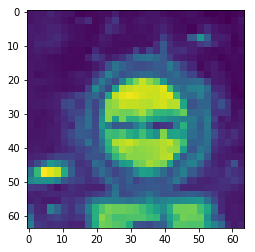

In [315]:
import matplotlib.pyplot as plt

plt.imshow(X_temp[50,:,:,0])
plt.show()


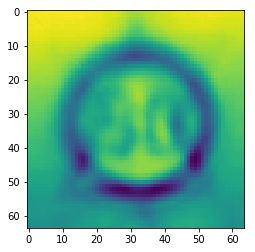

In [324]:
plt.imshow(np.std(X_temp[:,:,:,0],axis=0))
plt.show()

**Model architecture**

I use the same architecture as the german guys

![Model](model_architecture.png)



In [325]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# build a simple model
model = Sequential()

input_shape = (im_w, im_h, im_c)
num_classes = 2

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 64, 64, 32)        832       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 2048)              0         
__________

In [326]:
# compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [283]:
X, y = gen_trn[0]
X[:,1,1,0]

array([128.45074 , 180.68013 ,  40.91138 , 150.5195  ,  66.65825 ,
       101.23263 , 182.15137 ,  20.31388 ,  49.00325 , 142.42763 ,
       146.84137 ,  43.118256, 149.78387 ,  28.405754,  46.79638 ,
        62.2445  ,  98.29013 ,  15.90013 ,  46.060753, 114.47388 ,
       176.26637 ,  32.08388 , 105.64638 , 127.715126,  52.681377,
        55.623875,  68.86513 , 187.30075 ,  82.842   , 187.30075 ,
        89.46262 ,  36.49763 ], dtype=float32)

In [ ]:
# train the model

history = model.fit_generator(gen_trn, # input data
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=gen_val,
    validation_steps=STEP_SIZE_VAL,
    epochs=20,      
    verbose=1,
    class_weight={0:1, 1:8},
    use_multiprocessing=False)    

print('Training complete!')

Epoch 1/20
980/980 [==============================] - 112s 114ms/step - loss: 0.8329 - acc: 0.7867 - val_loss: 0.2721 - val_acc: 0.8914: 1:51 - loss: 1. - ETA: 1:43 - loss: 1.1273 - acc: 0.6 - ETA: 1:42 - loss: 1.1281 - acc: 0.6 - ETA: 1:41 - - ETA: 1:34 - loss: 1.1162 - acc: 0.6 - ETA: 1:34 - l - ETA: 1:13 - loss: 1.  - ETA: 1:02 - loss: 1.0327 - acc:  - ETA: 1:01 - loss: 1.0 - ETA: 1:00 - loss: 1 - ETA: 59s - loss: 1.0215 - acc - ETA: 58s - loss:  - ETA: 57s - loss: 1.0172 - acc: 0.71 - ETA: 57s - loss: 1. - ETA: 56s - loss: - ETA: 8s - loss: 0.8601  - ETA: 7s - loss: 0.8 - ETA: - ETA: 2s - loss:  - ETA: 0s - loss: 0.8335 - acc: 0.786 - ETA: 0s - loss: 0.8332 - acc: 0.786
Epoch 2/20
980/980 [==============================] - 103s 105ms/step - loss: 0.3669 - acc: 0.9167 - val_loss: 0.1498 - val_acc: 0.93800 - ETA: 1:19 - loss: 0.4895 - acc: 0.88 - ETA: 1:19 - loss: 0.4873 - ETA: 1:18 - loss: 0.4873 - acc: 0.8 - ETA: 1:17 - loss: 0.4868 - acc: 0.88  - ETA: 37s - loss:  - ETA: 20s - los

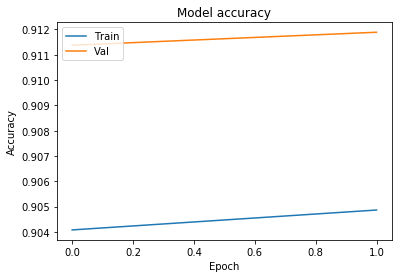

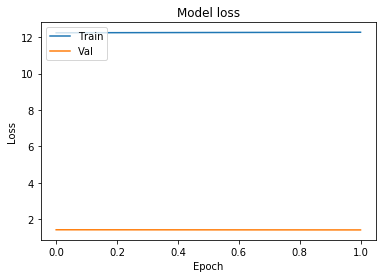

In [246]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [247]:
y_pred_tst = model.predict_generator(gen_tst, steps=STEP_SIZE_TST, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)

122/122 [==============================] - 2s 18ms/step


In [248]:
np.sum(y_pred_tst[:,:],axis=0)

array([3904.,    0.], dtype=float32)

In [249]:
import numpy as np
y_total = np.empty((0,2))
for i in range(0, STEP_SIZE_TST):
    (X,y) = gen_tst[0]
    y_total = np.concatenate((y_total,y), axis=0)

class_freq = np.sum(y_total,axis=0)
accuracy_chance = (class_freq[0]+class_freq[1]-class_freq[1])/(class_freq[1]+class_freq[0])
print('accuracy chance: %g' % accuracy_chance)

accuracy chance: 0.875


In [250]:
import sklearn.metrics
auc = sklearn.metrics.roc_auc_score(y_total, y_pred_tst)
print('model AUC: %g' % auc)

model AUC: 0.5


In [251]:
accuracy = sklearn.metrics.accuracy_score(y_total, y_pred_tst)
print('model accuracy: %g' % accuracy)

model accuracy: 0.875
